# Capstone - Financial Forecasting

Import fundamental packages

In [43]:
import pandas as pd
import numpy as np
from numpy import newaxis
#import pandas_datareader.data as web
import datetime
from datetime import timedelta
import seaborn as sn
from pandas import Series
from matplotlib import pyplot
from pandas import Series
from matplotlib import pyplot
# Pretty display for notebooks
%matplotlib inline
from IPython.display import display # Allows the use of display() for DataFrames
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from matplotlib.pyplot import savefig
import time
from scipy.misc import imresize
from sklearn.preprocessing import MinMaxScaler

In [44]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, LSTM, SimpleRNN
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import Model
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

C:\Users\Fabian\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Tensor Generation for Neural Networks, from complete dataframe pulled via API (Alphavantage , 08/18)

In this section, the 5 year dataframe that has been downloaded via quandl will be transformed into input images and targets. This section has to be run in order to supply the ANNs with data.

How the tensor is created
- Normalize entire 5 year dataframe for each company seperately
- Extract last 250 available data points (approx. 1 year of data) => 1 image 
- Shift one day for 5 years (2012-2017) -> ~250 images per year, Approximation:(5 * 250)-30 = 1220 images
- Final output: np array with dimensions: 1220 x 88 x 250 (1220 images x 88 companies x 250 timepoints in image)

Load dataset and PCA for sorting

In [153]:
companies = ["ADBE", "AKAM", "ALXN", "GOOGL", "AMZN", "AAL", "AMGN", "ADI", "AAPL", "AMAT", "ADSK", "ADP",
                  "BIDU", "BIIB", "BMRN", "CA", "CELG", "CERN", "CHKP", "CTAS", "CSCO", "CTXS", "CTSH", "CMCSA",
                  "COST", "CSX", "XRAY", "DISCA", "DISH", "DLTR", "EBAY", "EA", "EXPE", "ESRX", "FAST", "FISV",
                  "GILD", "HAS", "HSIC", "HOLX", "IDXX", "ILMN", "INCY", "INTC", "INTU", "ISRG", "JBHT", "KLAC",
                  "LRCX", "LBTYA", "MAR", "MAT", "MXIM", "MCHP", "MU", "MDLZ", "MSFT", "MNST", "MYL", "NFLX",
                  "NVDA", "ORLY", "PCAR", "PAYX", "QCOM", "REGN", "ROST", "STX", "SIRI", "SWKS", "SBUX", "SYMC",
                  "TSLA", "TXN", "TSCO", "TMUS", "FOX", "ULTA", "VRSK", "VRTX", "VIAB", "VOD", "WBA", "WDC",
                  "WYNN", "XLNX"]

In [158]:
mydata = pd.read_csv("C:/Users/Fabian/Documents/FinancialForecasting/ReferrenceData-2018724.csv", parse_dates = True, index_col = "date")
# Optional: Slice data
mydata = mydata[datetime.datetime(2012, 1, 1):datetime.datetime(2018, 12, 1)]

In [159]:
mydata.head()

,ATVI,ADBE,AKAM,ALXN,GOOGL,AMZN,AAL,AMGN,ADI,AAPL,...,FOX,ULTA,VRSK,VRTX,VIAB,VOD,WBA,WDC,WYNN,XLNX
date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,11.4188,28.57,32.93,70.57,333.7352,179.03,4.9299,55.4656,30.2745,52.2454,...,15.5222,63.3844,39.36,32.23,39.4604,16.5351,28.7648,26.7179,90.1301,27.6243
2012-01-04,11.3299,28.28,32.44,70.29,335.1747,177.51,4.8432,55.1628,30.2325,52.5262,...,15.4224,65.6291,38.98,32.20,39.4518,16.4707,28.5647,26.9939,88.5801,27.3305
2012-01-05,11.3346,28.48,32.43,72.41,330.5253,177.61,5.2669,55.7252,30.3669,53.1093,...,15.5638,68.7835,39.13,33.12,40.3715,16.2511,28.4690,28.2530,87.6549,27.5732
2012-01-06,11.4562,28.72,32.76,74.45,326.0164,182.61,5.3920,56.0280,30.1653,53.6645,...,15.4640,68.7439,39.37,34.05,40.7841,16.3038,28.7822,28.8826,84.5706,27.3944
2012-01-09,11.4188,28.53,32.61,74.27,312.1937,178.56,5.5076,55.5435,30.7534,53.5794,...,15.4640,69.1494,39.38,35.68,40.0535,16.1926,29.1476,29.1068,84.3334,27.9905


In [155]:
mydata.describe()

,ATVI,ADBE,AKAM,ALXN,GOOGL,AMZN,AAL,AMGN,ADI,AAPL,...,FOX,ULTA,VRSK,VRTX,VIAB,VOD,WBA,WDC,WYNN,XLNX
count,4669.000000,4669.000000,4669.000000,4669.000000,3507.000000,4669.000000,3228.000000,4669.000000,4669.000000,4669.000000,...,4669.000000,2705.000000,2214.000000,4669.000000,3180.000000,4669.000000,4669.000000,4669.000000,3963.000000,4669.000000
mean,15.323265,50.201947,38.496292,57.026635,425.517878,250.730998,25.815888,78.168344,37.639193,45.239356,...,18.813754,108.450127,60.806431,53.379790,39.599824,15.751376,41.260853,32.728653,78.426031,31.666196
std,16.968404,44.785438,33.306252,60.267177,275.942634,344.412950,17.248149,43.598233,18.828403,50.057446,...,8.249629,85.828808,22.186310,40.549359,15.849140,7.000614,19.683542,28.165554,50.185129,15.203309
min,0.428900,8.319100,0.670000,2.395000,50.159800,5.970000,1.694600,26.603000,12.258200,0.833400,...,4.585500,4.242100,26.250000,8.000000,9.947000,4.949500,17.519100,1.768000,6.487500,10.113400
25%,3.941500,25.825000,15.204000,6.725000,232.783600,39.100000,8.627200,48.745000,24.717700,3.664700,...,12.923500,24.622000,39.085000,25.490000,30.088725,9.849800,27.872400,9.754000,37.809400,19.949100
50%,10.340200,33.560000,35.480000,21.970000,303.682400,84.540000,27.587700,55.851700,30.940200,22.010800,...,15.436700,92.180000,62.375000,37.420000,35.218050,14.300100,32.515500,24.104800,70.467800,27.492000
75%,16.742500,56.700000,52.590000,113.600000,575.554150,306.450000,41.750225,102.201300,46.211500,76.153000,...,26.215700,168.320000,78.812500,77.820000,43.382050,22.713700,53.491100,48.126900,105.476050,40.499300
max,81.500000,259.780000,327.600000,207.840000,1258.150000,1843.930000,60.612200,195.910000,102.020000,193.980000,...,49.340000,313.730000,113.040000,182.590000,79.452600,31.179500,91.239000,105.183400,224.685900,76.683600


- PredictionTimepoints: number of datapoints for NN input data

In [161]:
# Number of companies (here: 88)
NumberofCompanies = mydata.shape[1]
#Define starting point for target and number of timepoints that are used as input (org: 250, 250)
PredictionTimepoints = 2
FirstIndex = PredictionTimepoints

MaxPoints = mydata.shape[0]-FirstIndex
print(MaxPoints)

1648


## 2.1 Data preparation for ANNs:
- In the next cell , inputs and targets are created for the NNs (specify with/without prior normalization, MLP/CNN, custom CNN/transfer learning CNN, stock prediction absolute/percent)
- Details: For all companies create input vector of past stock prices and output vector of the next day.
- Note: Three channel images are requiredfor transfer learning (here:Xception)! Solution: all 3 channels contain
the same pixels

Output: Complete input and output for multivariate in and output (MLP type 2 and CNN)

In [162]:
MLP = True# False => CNN
normalization = True

In [163]:
# create np array for Data Collection
DataCollection = np.empty([1,PredictionTimepoints,NumberofCompanies])
# Create np array for Target Collection
TargetCollection = np.empty([1,NumberofCompanies])

# Create copy of data frame for handling
mydataPP = mydata.copy(deep=True)
# Set StartIndex to FirstIndex
toPredictIndex = FirstIndex

#Normalization if required
if (normalization==True):
    mydataNP = mydata.values
    scaler = MinMaxScaler()  
    mydataNormalizedNP = scaler.fit_transform(mydataNP)
    mydataPP = pd.DataFrame(mydataNormalizedNP)

#FIRST define target day, THEN extract image of past data

for i in range(MaxPoints):
    
    #START CREATE OUTPUT VECTORS
    
    PredictTemp = mydataPP.iloc[toPredictIndex]
   
    arrayPredtemp = np.array(PredictTemp, np.float32)[newaxis,:]
    TargetCollection = np.append(TargetCollection, arrayPredtemp, axis=0)    
    
    
    #START CREATE INPUT VECTORS (IMAGES)
    end = toPredictIndex # e.g. first = 250
    start = end  - PredictionTimepoints # e.g. first = 0
     
    AdjCloseTemp = mydataPP.iloc[start : end] # e.g. 0 - 249 inclusive, as last index is not sliced
    
#     #Ordering for CNN
#     if (MLP==False):
#         arrayTemp = np.flip(np.transpose(np.array(AdjCloseTemp, np.float32)[:, :]),axis=1)
#         AdjCloseTemp = pd.DataFrame(arrayTemp)
#         AdjCloseTemp["cluster"] = preds
#         AdjCloseTemp = AdjCloseTemp.sort_values("cluster")
#         AdjCloseTemp = AdjCloseTemp.drop('cluster', 1)
#         arrayTemp = np.transpose(np.flip(AdjCloseTemp.values,axis=1))
#         AdjCloseTemp = pd.DataFrame(arrayTemp)
        
    AdjCloseTemp_Array = AdjCloseTemp.values
    

    arrayAdjClosedTemp = np.array(AdjCloseTemp_Array, np.float32)[newaxis, :,:]
    DataCollection = np.append(DataCollection, arrayAdjClosedTemp, axis=0)
    
    #END CREATE IMAGES
    
    toPredictIndex += 1

   
DataCollection = DataCollection[1:DataCollection.shape[0],:,:]
TargetCollection = TargetCollection[1:TargetCollection.shape[0],:]

#For CNN reshape is required
if (MLP==False):
    DataCollection  = DataCollection.reshape(DataCollection.shape[0], DataCollection.shape[1], DataCollection.shape[2], 1)
    
print(DataCollection.shape)
print(TargetCollection.shape)

(1648, 2, 87)
(1648, 87)


__MLP type 2 Data Splitting:__Train, test , validation split for MLP type 2

In [164]:
# Define number of Training samples (70 %), Validation (15%) and Testsamples (15%)
TrainingSamples = int(MaxPoints * 0.7)
ValidationSamples = int((MaxPoints-TrainingSamples)/2)
TestSamples = MaxPoints - TrainingSamples - ValidationSamples

In [165]:
X_train = np.copy(DataCollection[:TrainingSamples,:])
y_train = np.copy(TargetCollection[:TrainingSamples,:])
X_valid = np.copy(DataCollection[TrainingSamples-1:TrainingSamples+ValidationSamples,:])
y_valid = np.copy(TargetCollection[TrainingSamples-1:TrainingSamples+ValidationSamples,:])
X_test = np.copy(DataCollection[TrainingSamples+ValidationSamples-1:,:])
y_test = np.copy(TargetCollection[TrainingSamples+ValidationSamples-1:,:])

print(X_train.shape)

(1153, 2, 87)


# 3. Neural Network Training and scoring (Keras models)

## 3.1 MLP

MLP type 2:for multi company in and output

In [61]:
def MLP_B2():
    model = Sequential()
    model.add(Flatten(input_shape=(PredictionTimepoints, NumberofCompanies)))

   # model.add(Dense(5000, activation='relu'))
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(88))
    model.compile(loss='mean_squared_error', optimizer="adamax", metrics=['mse'])
    

    return model

In [ ]:
epochs = 2000

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# specify MLP 1 or 2 here

estimator = KerasRegressor(build_fn=MLP_B2, epochs=epochs, batch_size=TrainingSamples, verbose=1)

# Enter checkpoint filename here
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.new_data0617_MLPtype2_B2_Timepoints'+str(PredictionTimepoints)+'.hdf5', 
                               verbose=0, save_best_only=True)

estimator.fit(X_train, y_train,  validation_data=(X_valid, y_valid),callbacks=[checkpointer])

In [63]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
model = MLP_B2()
model.load_weights('saved_models_historic/weights.best.from_scratch_MLPtype2_B2_Timepoints'+str(PredictionTimepoints)+'.hdf5')

y_pred = model.predict(X_test)
print(r2_score(y_test,y_pred))

-10.78016731521492


# 4. Evaluate the Trained networks => Predict Profit

## 4.1 Profit for multi company forecast

## Start Second Try Fabi

In [108]:
y_test.shape

(190, 88)

In [109]:
X_test.shape

(190, 2, 88)

In [128]:
# Scale back
y_pred = model.predict(X_test)
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

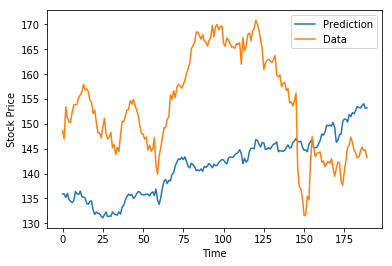

In [152]:
#Compare testset with predictions
plt.plot(y_pred_rescaled[:,7], label="Prediction")
plt.plot(y_test_rescaled[:,7], label="Data")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [134]:
# Calculate profit for every day investment in top percentual change company
Profit = []
TopCompanies = []
for i in range(0, y_test.shape[0]):
    X_test_rescaled_temp = scaler.inverse_transform(X_test[i,:,:]) 
    Delta = (y_test_rescaled[i,:]-X_test_rescaled_temp[1,:])/X_test_rescaled_temp[1,:]
    Delta_pred = (y_pred_rescaled[i,:]-X_test_rescaled_temp[1,:])/X_test_rescaled_temp[1,:]
    topindex = heapq.nlargest(1, range(len(Delta_pred)), Delta_pred.take)
    TopCompanies.append(companies[topindex[0]])
    Profit.append(100*Delta[topindex[0]])

In [138]:
CumulativeProfit = []
Money = 1
for i in range(0,len(Profit)):
    Money = (Profit[i])/100*Money + Money
    CumulativeProfit.append(Money)

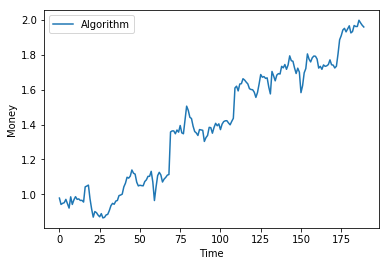

In [140]:
plt.plot(CumulativeProfit, label="Algorithm")
plt.xlabel("Time")
plt.ylabel("Money")
plt.legend()
plt.show()

In [141]:
TopCompanies

['WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/MU.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.11',
 'WIKI/STX.1

In [133]:
from scipy import stats
stats.describe(Profit)

DescribeResult(nobs=190, minmax=(-0.09887738268527058, 0.2183478720958451), mean=0.004013405502811302, variance=0.0009819693041247584, skewness=1.8684492156155337, kurtosis=12.146756825314595)

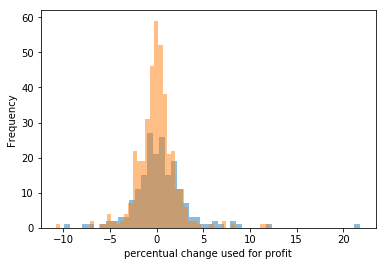

In [135]:
plt.hist(Profit, bins=50,alpha=0.5)
plt.hist(RandomPercentage, bins=50,alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel("percentual change used for profit")
plt.show()

## End Second try Fabi

Rescale targets and transform them into percentual changes 

In [88]:
y_test_cont = pd.DataFrame(scaler.inverse_transform(TargetCollection),copy=True)
y_temp = y_test_cont.copy(deep=True)
i=0

for entry in TargetCollection:

    if (i!=0):
        #print(y_test_cont.iloc[i])
        y_test_cont.iloc[i] = 100*(y_temp.iloc[i]-y_temp.iloc[i-1])/y_temp.iloc[i-1]
    i=i+1

y_test_cont=y_test_cont[1:].values

Predict for y_pred_cont and transform y_pred_cont to percentual values

In [97]:
model = MLP_B2()
model.load_weights('saved_models_historic/weights.best.from_scratch_MLPtype2_B2_Timepoints'+str(PredictionTimepoints)+'.hdf5')
#X_test_cont = np.copy(DataCollection[1:,:,:,:]) # For CNN
X_test_cont = np.copy(DataCollection[1:,:,:]) #for MLP
y_pred_cont = model.predict(X_test_cont)

In [90]:
y_pred_cont_df = pd.DataFrame(scaler.inverse_transform(y_pred_cont),copy=True)
i=0
for entry in y_pred_cont:
    
    #print(y_test_cont.iloc[i])
    y_pred_cont_df.iloc[i] = 100*(y_pred_cont_df.iloc[i]-y_temp.iloc[i])/y_temp.iloc[i]
    i=i+1
y_pred_cont=y_pred_cont_df.values

Check predictions (pred) and actual values (test)

In [68]:
#y_pred_cont

In [69]:
#y_test_cont

Set the maximum value in each timestep = 1 , other = 0

In [91]:
y_pred_cont_norm = (y_pred_cont == y_pred_cont.max(axis=1)[:,None]).astype(int)

y_pred_cont_norm_df = pd.DataFrame(y_pred_cont_norm,copy=True)
y_test_cont_df = pd.DataFrame(y_test_cont,copy=True)

Check for success

In [92]:
y_pred_cont_norm.sum().sum()

1255

Calculate profit: Every day only the maximum predicted positive stock change is used to invest all of startmoney

In [93]:
#Only profit from test range on
y_test_cont_df = y_test_cont_df[862:]
y_pred_cont_norm_df = y_pred_cont_norm_df[862:]

In [94]:
from random import randint

profitMulti = []
MaxPercentage =[]
RandomInvest = []
RandomPercentage = []
startmoney = 1.0
startmoneyrandom = 1.0

for row in y_test_cont_df.index:
    for column in y_test_cont_df.columns:
    
        if y_pred_cont_norm_df[column][row] != 0:
            startmoney=startmoney+(startmoney*y_test_cont_df[column][row]*y_pred_cont_norm_df[column][row]/100)
            profitMulti.append(startmoney)
            MaxPercentage.append(y_test_cont_df[column][row]*y_pred_cont_norm_df[column][row])
    startmoneyrandom = startmoneyrandom+(startmoneyrandom*y_test_cont_df[randint(0,len(y_test_cont_df.columns)-1)][row]/100)
    RandomInvest.append(startmoneyrandom) 
    RandomPercentage.append(y_test_cont_df[randint(0,len(y_test_cont_df.columns)-1)][row])

Plot Profit over time

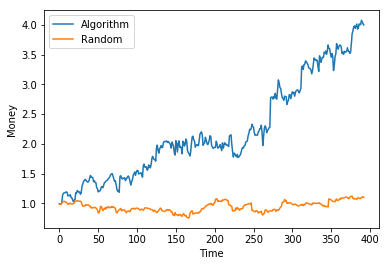

In [95]:
plt.plot(profitMulti, label="Algorithm")
plt.plot(RandomInvest,label="Random")
plt.xlabel("Time")
plt.ylabel("Money")
plt.legend()
plt.show()

In [75]:
profitMulti[150]

2.0521654055157263

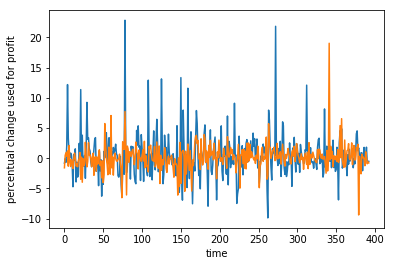

In [76]:
plt.plot(MaxPercentage)
plt.plot(RandomPercentage)
plt.ylabel("percentual change used for profit")
plt.xlabel("time")
plt.show()

In [77]:
from scipy import stats
stats.describe(MaxPercentage)

DescribeResult(nobs=393, minmax=(-9.887738268527059, 22.838909465843802), mean=0.4135283110537221, variance=12.554185542187634, skewness=1.756495033701957, kurtosis=8.444154214127872)

In [106]:
from scipy import stats
stats.describe(RandomPercentage)

DescribeResult(nobs=393, minmax=(-10.762605177006582, 12.041157969589225), mean=-0.023708148408011005, variance=4.394700507023412, skewness=0.5467255245100363, kurtosis=7.312848158482671)

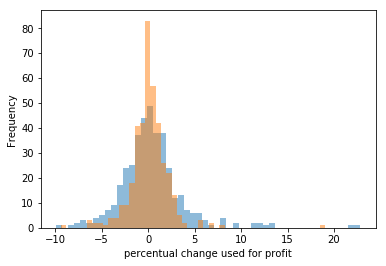

In [79]:
plt.hist(MaxPercentage, bins=50,alpha=0.5)
plt.hist(RandomPercentage, bins=50,alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel("percentual change used for profit")
plt.show()

In [17]:
import heapq
import numpy
a = numpy.array([1, 3, 2, 4, 5])
b = numpy.array([0, 3, 2, 4, 5])

In [39]:
import pickle

In [100]:
pickle_in = open("C:/Users/Fabian/Documents/FinancialForecasting/Data/X_score-2018725.pickle", "rb")
X_score = pickle.load(pickle_in)

In [101]:
X_score.shape

(1, 2, 87)

In [104]:
bla = X_score[0]

In [105]:
bla[1,:]

array([0.88864499, 0.79365009, 0.7707653 , 0.34780079, 0.83917314,
       0.81637293, 0.91059989, 0.95030236, 0.84797478, 0.87474161,
       0.96922243, 0.80752271, 0.74343491, 0.87360334, 0.47583315,
       0.4294017 , 0.68973458, 0.5089792 , 0.77787632, 0.80533469,
       0.79976982, 0.92993671, 0.77928394, 0.96933979, 0.80846685,
       0.81984121, 0.73195529, 0.64977682, 0.27075213, 0.29012758,
       0.84753305, 0.90846777, 0.82331413, 0.619524  , 0.5857234 ,
       0.925475  , 0.91367137, 0.62500304, 0.79328805, 0.54954135,
       0.73218429, 0.72275901, 0.73048049, 0.55345225, 0.83682525,
       0.7079252 , 0.75293577, 0.860165  , 0.9313848 , 0.89588088,
       0.35606039, 0.91643763, 0.13709155, 0.93382007, 0.90916902,
       0.84543079, 0.9625504 , 0.82370991, 0.76021749, 0.40761459,
       0.77205551, 0.902888  , 0.78412682, 0.8207503 , 0.8582263 ,
       0.69476247, 0.51691324, 0.88726717, 0.87106502, 0.78056496,
       0.96193415, 0.85037827, 0.71255267, 0.84318489, 0.90111